# With Synthetic Data

In [1]:
import os
PATH = os.getenv("HOME")
os.chdir(f"{PATH}/watttime-python-client-aer-algo")

import pandas as pd
import evaluation.eval_framework as evu
from datetime import datetime

import seaborn as sns
import evaluation.metrics as m

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")


In [19]:
from datetime import timedelta

In [2]:
import random
import math
from watttime import WattTimeForecast, WattTimeHistorical
import data.s3 as s3u

In [3]:
s3 = s3u.s3_utils()

## Analysis Details
- 2024 dates only
- 1000 users
- sanity check on 9 current regions + 9 randomly selected other regions
- set of requery increments to test: none, 5,15,60,180
- charging windows of lengths 3,6,12 hours
- Charge needed at least 45 minutes (25% of smallest window)

### Regions

In [4]:
original_regions = [
    "SPP_TX",
    "ERCOT_EASTTX",
    "FPL",
    "SOCO",
    "PJM_CHICAGO",
    "LDWP",
    "PJM_DC",
    "NYISO_NYC",
]

#from evaluation.config import MOER_REGION_LIST
#random_regions = random.sample([elem for elem in MOER_REGION_LIST if elem not in regions], 9)

random_regions = [
    'PACE',
    'PNM',
    'MISO_INDIANAPOLIS',
    'WALC',
    'SPP_FORTPECK',
    'SPP_KANSAS',
    'AECI',
    'BANC',
    'PJM_SOUTHWEST_OH'
]

regions = original_regions+random_regions

In [5]:
df_req = s3.load_csvdataframe("requery_data/20241203_1k_synth_users_96_days.csv")

<Axes: ylabel='Frequency'>

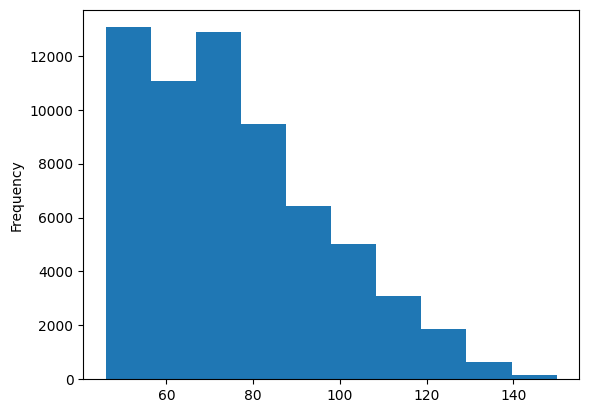

In [6]:
df_req.usage_time_required_minutes.plot(kind='hist')

In [8]:
forecast_generator = WattTimeForecast(username, password)
historical_generator = WattTimeHistorical(username, password)

### Single test

In [37]:
import importlib
importlib.reload(evu)

<module 'evaluation.eval_framework' from '/home/jennifer.badolato/watttime-python-client-aer-algo/evaluation/eval_framework.py'>

In [7]:
def sanitize_time_needed(x,y):
    return int(math.ceil(min(x, y) / 300.0) * 5)

def sanitize_total_intervals(x):
    return math.ceil(x)

In [8]:
optimization_method = "auto"
requery_intervals = [5,15,60,180]
region = "PJM_SOUTHWEST_OH"

full_forecast = s3.load_parquetdataframe(
    f"complete_2024_forecast_history/{region}.parquet"
).drop_duplicates()
full_forecast["point_time"] = pd.to_datetime(
    full_forecast["point_time"], utc=True
)
full_history = s3.load_parquetdataframe(
    f"complete_2024_actual_history/{region}.parquet"
).drop_duplicates()

In [9]:
# Sanitize input data
df_req["sanitize_intervals_plugged_in"] = df_req.apply(lambda x: sanitize_total_intervals(x.total_intervals_plugged_in), axis=1)
df_req["sanitize_time_needed"] = df_req.apply(lambda x: sanitize_time_needed(x.total_seconds_to_95, x.length_of_session_in_seconds), axis=1)

In [12]:
synth_data = df_req.tail(10).copy()

In [13]:
synth_data.session_start_time = pd.to_datetime(synth_data.session_start_time)
synth_data.session_end_time = pd.to_datetime(synth_data.session_end_time)

In [14]:
synth_data.head(1).T

,63678
index,86
distinct_dates,2024-10-28
user_type,r33.5325_tc113_avglc28597_sdlc7455_contFalse
session_start_time,2024-10-28 07:27:11
session_end_time,2024-10-28 10:27:11
initial_charge,0.500079
total_seconds_to_95,5458.218019
full_charge_time,2024-10-28 08:58:09.218018653
length_of_session_in_seconds,10800.0
charged_kWh_actual,50.841027


In [17]:
time_zone = evu.get_timezone_from_dict(region)                    
start_time = pd.Timestamp(evu.convert_to_utc(synth_data.iloc[0]['session_start_time'].round('5min') , time_zone))
end_time = pd.Timestamp(evu.convert_to_utc(synth_data.iloc[0]['session_end_time'].round('5min'), time_zone))
time_needed = synth_data.iloc[0]["sanitize_time_needed"]
usage_power_kw = synth_data.iloc[0]["power_output_rate"]

In [48]:
from watttime.api import RecalculatingWattTimeOptimizer, WattTimeOptimizer

In [50]:
wt_opt_rc = RecalculatingWattTimeOptimizer(
    region=region,
    watttime_username=username,
    watttime_password=password,
    usage_time_required_minutes=time_needed,
    usage_power_kw=usage_power_kw,
    optimization_method=optimization_method,
)

wt_opt = WattTimeOptimizer(username, password)

In [51]:
all_relevant_forecasts = full_forecast.set_index("generated_at")[
    start_time - timedelta(minutes=5) : end_time
].reset_index()
all_relevant_forecasts = all_relevant_forecasts.set_index("generated_at")[
    start_time - timedelta(minutes=5) : end_time
]

In [52]:
inc_times = pd.date_range(
            all_relevant_forecasts.index.min(),
            all_relevant_forecasts.index.max(),
            freq=timedelta(minutes=60),
        )

In [53]:
moer_list = [
            all_relevant_forecasts.loc[timestamp].reset_index()
            for timestamp in inc_times
        ]

In [54]:
new_start_time = start_time

In [58]:
new_start_time

Timestamp('2024-10-28 11:25:00+0000', tz='UTC')

In [41]:
for curr_fcst_data in moer_list:
    new_start_time = pd.Timestamp(curr_fcst_data["point_time"].min())
    while new_start_time < end_time:
        wt_opt_rc.get_new_schedule(
            new_start_time=new_start_time,
            new_end_time=end_time,
            curr_fcst_data=curr_fcst_data,
        )

IndexError: invalid index to scalar variable.

In [55]:
curr_fcst_data["point_time"] = pd.to_datetime(curr_fcst_data["point_time"])
curr_fcst_data = curr_fcst_data[curr_fcst_data["point_time"] >= new_start_time]
new_schedule_start_time = curr_fcst_data["point_time"].iloc[0]

In [56]:
curr_fcst_data.head()

,generated_at,point_time,value,region
1,2024-10-28 11:20:00+00:00,2024-10-28 11:25:00+00:00,1205.6,PJM_SOUTHWEST_OH
2,2024-10-28 11:20:00+00:00,2024-10-28 11:30:00+00:00,1205.5,PJM_SOUTHWEST_OH
3,2024-10-28 11:20:00+00:00,2024-10-28 11:35:00+00:00,1206.2,PJM_SOUTHWEST_OH
4,2024-10-28 11:20:00+00:00,2024-10-28 11:40:00+00:00,1207.3,PJM_SOUTHWEST_OH
5,2024-10-28 11:20:00+00:00,2024-10-28 11:45:00+00:00,1208.0,PJM_SOUTHWEST_OH


In [61]:
new_schedule = wt_opt.get_optimal_usage_plan(
    region = region,
    usage_window_start = new_start_time - timedelta(minutes=5),
    usage_window_end = end_time,
    usage_time_required_minutes = time_needed,
    usage_power_kw = usage_power_kw,
    optimization_method = optimization_method,
    moer_data_override=curr_fcst_data,
    charge_per_interval=None,
)

IndexError: invalid index to scalar variable.

In [45]:
wt_opt_rc.get_optimal_usage_plan(
    region,
    new_start_time - timedelta(minutes=5),
    end_time,
    time_needed,
    usage_power_kw,
    optimization_method=optimization_method,
    moer_data_override=curr_fcst_data,
    charge_per_interval=None,
)


AttributeError: 'RecalculatingWattTimeOptimizer' object has no attribute 'get_optimal_usage_plan'

In [42]:
wt_opt_rc._get_new_schedule(
    new_start_time=new_start_time,
    new_end_time=end_time,
    curr_fcst_data=curr_fcst_data,
)

IndexError: invalid index to scalar variable.